# **Business Context** 

* Banks are primarily known for money lending business. The more money they lend to people whom they can get good interest with timely repayment, the more revenue is for the banks.

* The more banks are able to identify borrowers going towards serious delinquency rate, the better will be the bank's money lending business which in turn will lead to better revenue and better image in the market and with respect to competitiors. 
* **
*  **Delinquent** in general is a slightly mild term where a borrower is not repaying charges and is behind by certain months whereas, 
* **Default** is a term where a borrower has not been able to pay charges and is behind for a long period of months and is unlikely to repay the charges.
* We have a general profile about the borrower such as age, Monthly Income, Dependents and the historical data such as what is the Debt Ratio, what ratio of amount is owed wrt credit limit, and the no of times defaulted in the past one, two, three months.
* We will be using all these features to predict whether the borrower is likely to delinquent in the next 2 years or not.
* These kind of predictions will help banks to take necessary actions.
* **
* **Objective** : Building a model using the inputs/attributes which are general profile and historical records of a borrower to predict whether one is likely to have serious delinquency in the next 2 years 

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import math
from scipy.stats import skew, kurtosis
from scipy import stats, special
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Importing ML algorithms
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, accuracy_score,confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [3]:
# Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display, HTML
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# All floating values upto two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# Function to check for missing values
def missing_check(df):
    '''
    Computes the statistics for missing values
    Args:
      df: A pandas dataframe

    Returns:
      missing: A dataframe of missing value stats    
    '''
    n_obs = df.shape[0]
    df = df.isna().sum().sort_values(ascending = False)
    missing = pd.DataFrame()
    missing['Feature'] = df.index
    missing['Count of missing_values'] = df.to_numpy()
    missing['Percentage of Total'] = df.to_numpy()/n_obs*100
    return missing

# Function to check for duplicate values
def duplicates_check(df, remove_duplicates = False):
    '''
    checks for duplicate records in a dataframe
    Args:
      df: A pandas dataframe
      remove_duplicates: if set to true then remove the duplicate records

    Returns:
      if remove_duplicates = True, returns a dataframe with duplicate records removed      
    '''
    if df.duplicated().sum() != 0:
        df = df[df.duplicated(keep = 'first')]
        print("Following records are duplicated in the dataset:\n")
        display(df)
        if remove_duplicates:
            df = df.drop_duplicates(keep = 'first')
        return df
    else:
        print("No duplicated records found in the dataset")
        
        
# Statistical functions
def SkewMeasure(df):
    '''
    Computes the skewness of numerical variables
    Args:
      df: A pandas dataframe
    Returns:
      A dataframe of variables having skewness > 0.5  
    '''
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    skewM = df[nonObjectColList].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
    skewM = pd.DataFrame({'skew':skewM})
    return skewM[abs(skewM)>0.5].dropna()


# Function to plot ditribution of variables for EDA
def plot_kde_box(df, col):
    '''
    kde and box plots of numerical feature
    Args:
       df: A pandas dataframe
       col: variable to plot
    '''
    df = df[df[col].notnull()]
    fig, [ax1,ax2] = plt.subplots(1,2, figsize = (12,6))
    sns.kdeplot(data = df, x = col, fill = True, ax = ax1)
    sns.boxplot(data = df, y = col, ax = ax2)
    print("skewness : ",skew(df[col]))
    print("kurtosis : ",kurtosis(df[col]))
    plt.show()

def plot_count_box(df, col):
    '''
    count and box plots of non-numerical feature
    Args:
       df: A pandas dataframe
       col: variable to plot
    '''
    df = df[df[col].notnull()]
    fig, [ax1,ax2] = plt.subplots(1,2, figsize = (12,6))
    sns.countplot(data = df, x = col, ax = ax1)
    sns.boxplot(data = df, y = col, ax = ax2)
    print("skewness : ",skew(df[col]))
    print("kurtosis : ",kurtosis(df[col]))
    plt.show()

def plot_box_violin(df, col1, col2):
    '''
    kde and box plots of numerical feature
    Args:
       df: A pandas dataframe
       col: variable to plot
    '''
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
    sns.boxplot(x=col1, y=col2, data = df, palette='Set3',ax=ax1)
    sns.violinplot(x=col1, y=col2, data = df, palette='Set3',ax=ax2)
    plt.show()

In [5]:
# Read the data
data = pd.read_csv('data/cs-training.csv')
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.77,45,2,0.80,9120.00,13,0,6,0,2.00
1,2,0,0.96,40,0,0.12,2600.00,4,0,0,0,1.00
2,3,0,0.66,38,1,0.09,3042.00,2,1,0,0,0.00
3,4,0,0.23,30,0,0.04,3300.00,5,0,0,0,0.00
4,5,0,0.91,49,1,0.02,63588.00,7,0,1,0,0.00


In [6]:
# info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [7]:
# Renaming the unnamed column
data.rename(columns = {'Unnamed: 0' : 'Customer_id'}, inplace = True)

In [8]:
# Check for Null values
missing_check(data)

,Feature,Count of missing_values,Percentage of Total
0,MonthlyIncome,29731,19.82
1,NumberOfDependents,3924,2.62
2,Customer_id,0,0.00
3,SeriousDlqin2yrs,0,0.00
4,RevolvingUtilizationOfUnsecuredLines,0,0.00
5,age,0,0.00
6,NumberOfTime30-59DaysPastDueNotWorse,0,0.00
7,DebtRatio,0,0.00
8,NumberOfOpenCreditLinesAndLoans,0,0.00
9,NumberOfTimes90DaysLate,0,0.00


In [9]:
# Check for duplicate values
duplicates_check(data)

No duplicated records found in the dataset


In [10]:
# data statistics
quants = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
data.describe(percentiles = quants).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Customer_id,150000.00,75000.50,43301.41,1.00,1500.99,15000.90,37500.75,75000.50,112500.25,135000.10,148500.01,150000.00
SeriousDlqin2yrs,150000.00,0.07,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
RevolvingUtilizationOfUnsecuredLines,150000.00,6.05,249.76,0.00,0.00,0.00,0.03,0.15,0.56,0.98,1.09,50708.00
age,150000.00,52.30,14.77,0.00,24.00,33.00,41.00,52.00,63.00,72.00,87.00,109.00
NumberOfTime30-59DaysPastDueNotWorse,150000.00,0.42,4.19,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.00,98.00
DebtRatio,150000.00,353.01,2037.82,0.00,0.00,0.03,0.18,0.37,0.87,1267.00,4979.04,329664.00
MonthlyIncome,120269.00,6670.22,14384.67,0.00,0.00,2005.00,3400.00,5400.00,8249.00,11666.00,25000.00,3008750.00
NumberOfOpenCreditLinesAndLoans,150000.00,8.45,5.15,0.00,0.00,3.00,5.00,8.00,11.00,15.00,24.00,58.00
NumberOfTimes90DaysLate,150000.00,0.27,4.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,98.00
NumberRealEstateLoansOrLines,150000.00,1.02,1.13,0.00,0.00,0.00,0.00,1.00,2.00,2.00,4.00,54.00


In [11]:

# Target variable - SeriousDlqin2yrs
unq = data['SeriousDlqin2yrs'].unique()
print("Unique values in the target feature = ", unq)

Unique values in the target feature =  [1 0]


0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64


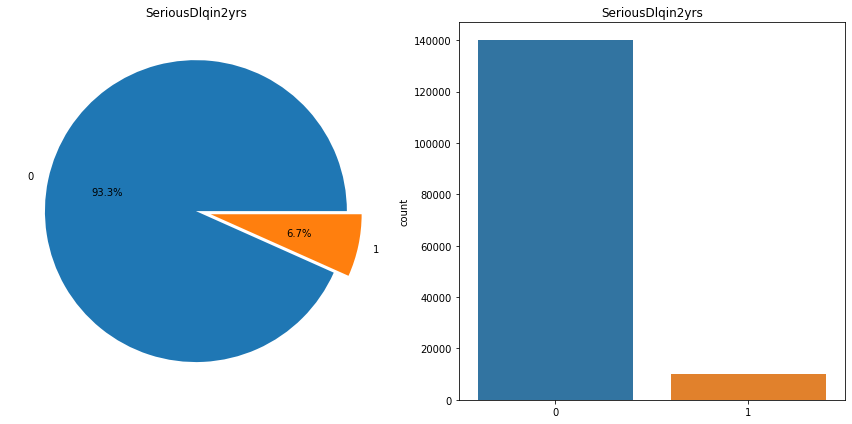

In [12]:
print(data['SeriousDlqin2yrs'].value_counts())

fig, ax = plt.subplots(1,2,figsize=(12,6))
data['SeriousDlqin2yrs'].value_counts().plot(kind = 'pie', explode=[0,0.1],autopct='%1.1f%%',ax=ax[0])
ax[0].set_title('SeriousDlqin2yrs')
ax[0].set_ylabel('')
sns.countplot(x = 'SeriousDlqin2yrs', data = data, ax=ax[1])
ax[1].set_title('SeriousDlqin2yrs')
ax[1].set_xlabel('')
plt.tight_layout()
plt.show();

In [13]:
df_train, df_val = train_test_split(data, test_size = 0.2, stratify = data['SeriousDlqin2yrs'], random_state = 105)

In [14]:
df_train.shape, df_val.shape

((120000, 12), (30000, 12))

In [15]:
# Event rate in the data
print("Event rate in the entire dataset : %.2f%%" %(np.mean(data['SeriousDlqin2yrs'])*100))
print("Event rate in the train set : %.2f%%" %(np.mean(df_train['SeriousDlqin2yrs'])*100))
print("Event rate in the test set : %.2f%%" %(np.mean(df_val['SeriousDlqin2yrs'])*100))

Event rate in the entire dataset : 6.68%
Event rate in the train set : 6.68%
Event rate in the test set : 6.68%


Even rate is maintained in all the data subsets

## **Univariate Analysis**

skewness :  103.06629263854617
kurtosis :  15370.622432900776


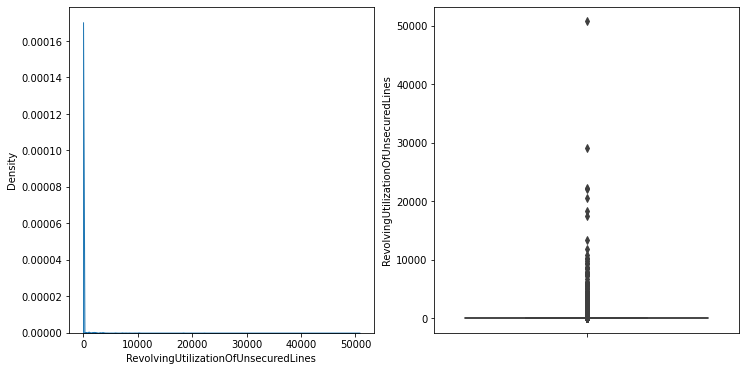

In [16]:
plot_kde_box(df_train, 'RevolvingUtilizationOfUnsecuredLines')

skewness :  0.19043021137872096
kurtosis :  -0.4947972341072604


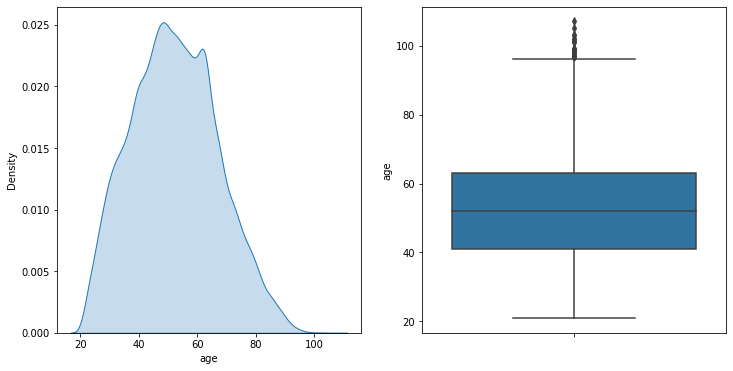

In [17]:
plot_kde_box(df_train,'age')

skewness :  113.35218556344388
kurtosis :  18370.39370246715


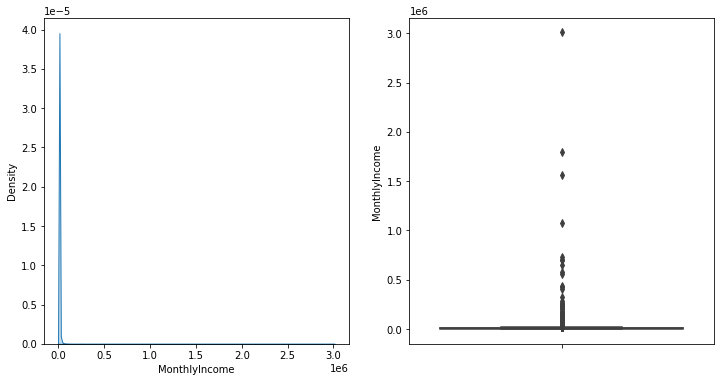

In [18]:
plot_kde_box(df_train, 'MonthlyIncome')

skewness :  100.84432161655674
kurtosis :  14493.524717592134


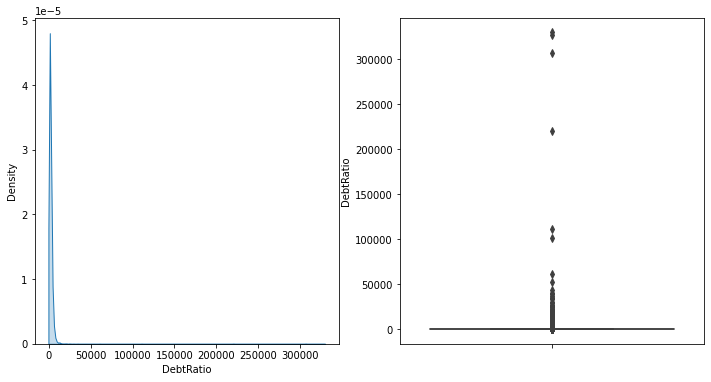

In [19]:
plot_kde_box(df_train, 'DebtRatio')

skewness :  1.2051248960472287
kurtosis :  2.9578352852154826


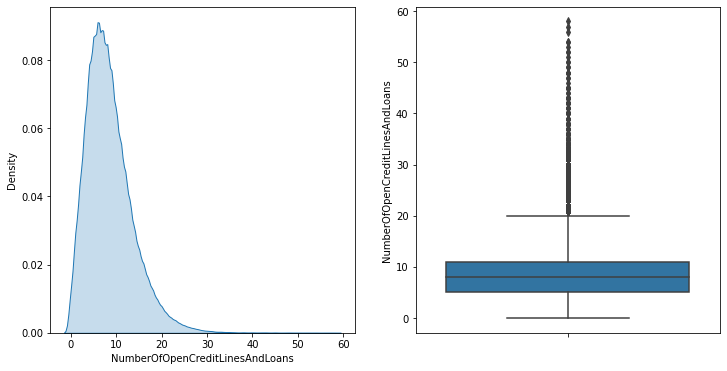

In [20]:
plot_kde_box(df_train,'NumberOfOpenCreditLinesAndLoans')

skewness :  3.43507143769219
kurtosis :  63.828170832741534


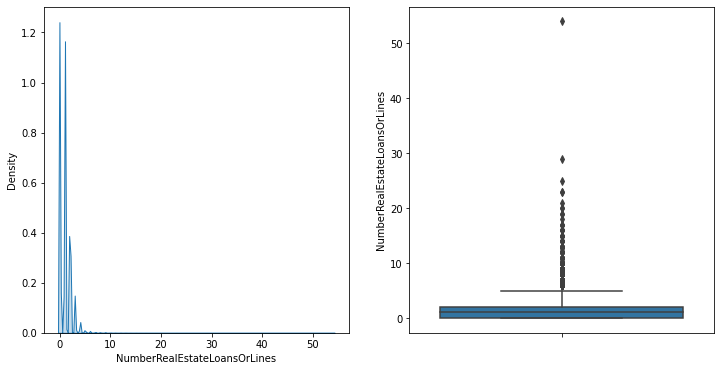

In [21]:
plot_kde_box(df_train, 'NumberRealEstateLoansOrLines')

skewness :  1.5908924279828114
kurtosis :  3.135624725048305


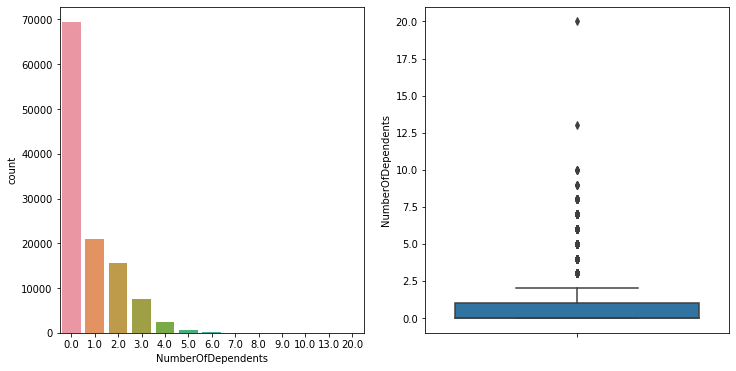

In [22]:
plot_count_box(df_train, 'NumberOfDependents')

skewness :  22.907593055297973
kurtosis :  537.2380439573474


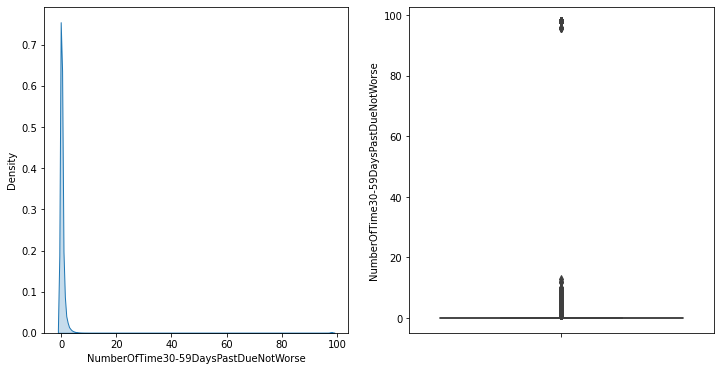

In [23]:
plot_kde_box(df_train, 'NumberOfTime30-59DaysPastDueNotWorse')

skewness :  23.672874612576194
kurtosis :  561.8728374363047


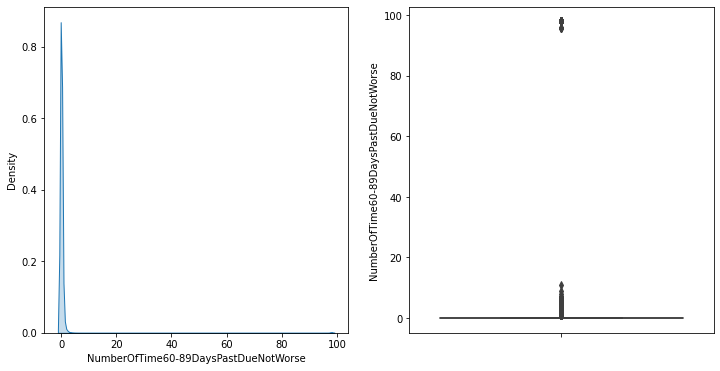

In [24]:
plot_kde_box(df_train,'NumberOfTime60-89DaysPastDueNotWorse')

skewness :  23.418703268321483
kurtosis :  553.4961973830897


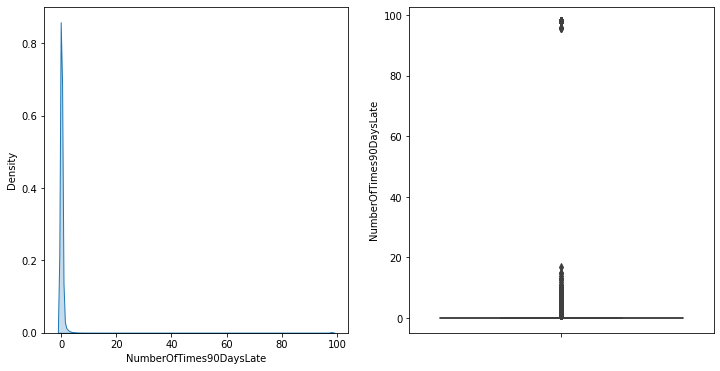

In [25]:
plot_kde_box(df_train, 'NumberOfTimes90DaysLate')

In [26]:
cols_for_stats = ['RevolvingUtilizationOfUnsecuredLines', 'age',
                  'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
                  'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
                  'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
                  'NumberOfDependents']

skewness  = [] 
kurt = []
for col in cols_for_stats:
    skewness.append(skew(df_train[df_train[col].notnull()][col]))
    kurt.append(kurtosis(df_train[df_train[col].notnull()][col]))
    
stats = pd.DataFrame({'Skewness' : skewness, 'Kurtosis' : kurt}, index=[col for col in cols_for_stats])
stats.sort_values(by=['Skewness'], ascending=False)                  

,Skewness,Kurtosis
MonthlyIncome,113.35,18370.39
RevolvingUtilizationOfUnsecuredLines,103.07,15370.62
DebtRatio,100.84,14493.52
NumberOfTime60-89DaysPastDueNotWorse,23.67,561.87
NumberOfTimes90DaysLate,23.42,553.50
NumberOfTime30-59DaysPastDueNotWorse,22.91,537.24
NumberRealEstateLoansOrLines,3.44,63.83
NumberOfDependents,1.59,3.14
NumberOfOpenCreditLinesAndLoans,1.21,2.96
age,0.19,-0.49


*  Data distribution in the columns are highly right skewed with very high kurtosis value showing extreme outliers in those columns
*  Except age which is little normally distributed

## Data Cleaning
### Outlier Treatement
* *From the above boxplot graphs we can observe:*
1. *In the columns 'NumberOfTime30-59DaysPastDueNotWorse' , 'NumberOfTime60-89DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate', we see delinquency range beyond 90 which is common across all 3 features.*
2. *Treating outliers for the columns  -- 'NumberOfTime30-59DaysPastDueNotWorse' , 'NumberOfTime60-89DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate'*

In [27]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",
      np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",
      np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",
      np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['NumberOfTimes90DaysLate']))


print("Unique values in '30-59 Days' values that are less than 90:",
      np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",
      np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",
      np.unique(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTimes90DaysLate']))


print("Proportion of positive class with special 96/98 values:",
      round(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs'].sum()*100/
      len(df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs']),2),'%')

Unique values in '30-59 Days' values that are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '30-59 Days' values that are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 12 13]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]
Proportion of positive class with special 96/98 values: 55.02 %


* *We can see from the following that when records in column 'NumberOfTime30-59DaysPastDueNotWorse' are more than 90, the other columns that records number of times payments are past due X days also have the same values. We will classify these as special labels since the proportion of positive class is abnormally high at 55.02%.*
* **
* *These 96 and 98 values can be viewed as accounting errors. Hence, we would replace them with the maximum value before 96 i.e. 12, 11 and 17*


In [28]:
df_train.loc[df_train['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 12
df_train.loc[df_train['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
df_train.loc[df_train['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17

In [29]:
print("Unique values in 30-59Days", np.unique(df_train['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(df_train['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(df_train['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 12 13]
Unique values in 60-89Days [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]


In [30]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",
      np.unique(df_val[df_val['NumberOfTime30-59DaysPastDueNotWorse']>=90]['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",
      np.unique(df_val[df_val['NumberOfTime30-59DaysPastDueNotWorse']>=90]['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",
      np.unique(df_val[df_val['NumberOfTime30-59DaysPastDueNotWorse']>=90]['NumberOfTimes90DaysLate']))


print("Unique values in '30-59 Days' values that are less than 90:",
      np.unique(df_val[df_val['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTime30-59DaysPastDueNotWorse']))


print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",
      np.unique(df_val[df_val['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTime60-89DaysPastDueNotWorse']))


print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",
      np.unique(df_val[df_val['NumberOfTime30-59DaysPastDueNotWorse']<90]['NumberOfTimes90DaysLate']))

Unique values in '30-59 Days' values that are more than or equal to 90: [98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [98]
Unique values in '30-59 Days' values that are less than 90: [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [0 1 2 3 4 5 6 7 8]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]


* Since, these values exist in Validation Set as well. Therefore, replacing them with maximum values before 96 and 98 i.e. 13, 7 and 15.*

In [31]:
df_val.loc[df_val['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
df_val.loc[df_val['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 7
df_val.loc[df_val['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 15

print("Unique values in 30-59Days", np.unique(df_val['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(df_val['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(df_val['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 11 13]
Unique values in 60-89Days [0 1 2 3 4 5 6 7 8]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15]


* Checking for  **DebtRatio** and  **RevolvingUtilizationOfUnsecuredLines.**

In [32]:
# Debt ratio
df_train['DebtRatio'].describe()

count   120000.00
mean       353.11
std       2111.19
min          0.00
25%          0.18
50%          0.37
75%          0.87
max     329664.00
Name: DebtRatio, dtype: float64

In [33]:
# RevolvingUtilizationOfUnsecuredLines
df_train['RevolvingUtilizationOfUnsecuredLines'].describe()

count   120000.00
mean         5.94
std        259.41
min          0.00
25%          0.03
50%          0.15
75%          0.56
max      50708.00
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

* **Debt Ratio**
* As we can see data is right skewed. So, our main aim would be to check the potential outliers beyond 95% quantiles. However, since our data is 120,000, let's consider 95% and 97.5% quantiles for our further analysis.

In [34]:
df_train[df_train['DebtRatio'] >= df_train['DebtRatio'].quantile(0.95)][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,6001.00,292.00
mean,0.06,0.09
std,0.23,0.29
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,1.00,1.00


* Here we can observe:
* **
* Out of 6001 customers falling in the last 5 percentile of the data i.e. the number of times their debt is higher than their income, only 292 have Monthly Income values.
* The Max for Monthly Income is 1 and Min is 0 which makes us wonder that are data entry errors. Let's check whether the Serious Delinquency in 2 years and Monthly Income values are equal.

In [35]:
df_train[(df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)) & 
         (df_train['SeriousDlqin2yrs'] == df_train['MonthlyIncome'])].shape[0]

253

* Hence, our suspicions are true and there are 253 out of 292 rows where Monthly Income is equal to the Serious Delinquencies in 2 years. Hence we will remove these 253 outliers from our analysis as their current values aren't useful for our predictive modelling and will add to the bias and variance.

In [36]:
df_train_new = df_train[-((df_train["DebtRatio"] > df_train["DebtRatio"].quantile(0.95)) & 
                          (df_train['SeriousDlqin2yrs'] == df_train['MonthlyIncome']))]
df_train_new.shape

(119747, 12)

* **Revolving Utilization of Unsecured Lines**
* This field basically represents the ratio of the amount owed by the credit limit of a customer. A ratio higher than 1 is considered to be a serious defaulter. A Ratio of 10 functionally also seems possible, let's see how many of these customers have the Revolving Utilization of Unsecured Lines greater than 10.

In [37]:
quants = [0, 0.1, 0.25, 0.5, 0.75, 0.9]
df_train_new[df_train_new['RevolvingUtilizationOfUnsecuredLines']>10].describe(percentiles = quants).T

,count,mean,std,min,0%,10%,25%,50%,75%,90%,max
Customer_id,185.00,77478.81,40717.62,294.00,294.00,18670.20,45755.00,79094.00,108192.00,130590.40,149280.00
SeriousDlqin2yrs,185.00,0.07,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
RevolvingUtilizationOfUnsecuredLines,185.00,3646.37,5526.37,11.39,11.39,309.00,941.00,2012.00,3853.00,7867.80,50708.00
age,185.00,50.13,14.46,24.00,24.00,33.00,38.00,48.00,60.00,70.00,87.00
NumberOfTime30-59DaysPastDueNotWorse,185.00,0.15,0.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
DebtRatio,185.00,570.08,1859.01,0.00,0.00,0.12,0.23,0.42,121.00,2147.20,21395.00
MonthlyIncome,133.00,8266.80,6473.10,0.00,0.00,2653.00,4260.00,7222.00,10000.00,14616.00,44472.00
NumberOfOpenCreditLinesAndLoans,185.00,5.78,3.13,1.00,1.00,2.00,4.00,5.00,7.00,9.60,21.00
NumberOfTimes90DaysLate,185.00,0.09,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.00
NumberRealEstateLoansOrLines,185.00,1.21,1.08,0.00,0.00,0.00,0.00,1.00,2.00,2.00,9.00


In [38]:
df_train_new[(df_train_new['RevolvingUtilizationOfUnsecuredLines']>10) & (df_train_new['SeriousDlqin2yrs'] == 1)].shape

(13, 12)

* Despite owing thousands, out of these these 185 people , 13 people are falling in the serious delinquency which means this might be another error. Even if it is not an error, these numbers will add huge bias and variance to our final predictions. Therefore, the best decision is to remove these values.

In [39]:
df_train_new = df_train_new[df_train_new['RevolvingUtilizationOfUnsecuredLines']<=10].copy()
df_train_new.shape

(119562, 12)

In [40]:
df_val_new = df_val[df_val['RevolvingUtilizationOfUnsecuredLines']<=10].copy()
df_val_new.shape

(29944, 12)

* **Age**

In [41]:
df_train_new[df_train_new['age']<1]

,Customer_id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents


In [42]:
df_val_new[df_val_new['age']<1]

,Customer_id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.00,0,1,0.44,6000.00,6,0,2,0,2.00


* We will be replacing the error/odd value with the mode

In [43]:
df_val_new.loc[df_val_new['age'] == 0, 'age'] = df_train_new['age'].mode()[0]

In [44]:
df_val_new['age'].min()

21

### **Missing Value Treatment**
* Features with missing values --> MonthlyIncome, Number of Dependents
* *Since MonthlyIncome is an integer value, we will replace the nulls with the median values instead of mean as it is heavily right skewed.*
* *Number of Dependents can be characterized as a categorical variable, hence if customers have NA for number of dependents, it means that they do not have any dependents. 
Filling either by mode which is 0 or by the above assumption is the same.Therefore, we fill them with zeros.*

In [45]:
df_train_new['MonthlyIncome'].fillna(df_train_new['MonthlyIncome'].median(), inplace=True)
df_train_new['NumberOfDependents'].fillna(0, inplace = True)

In [46]:
df_val_new['MonthlyIncome'].fillna(df_train_new['MonthlyIncome'].median(), inplace=True)
df_val_new['NumberOfDependents'].fillna(0, inplace = True)

In [47]:
missing_check(df_val_new)

,Feature,Count of missing_values,Percentage of Total
0,Customer_id,0,0.00
1,SeriousDlqin2yrs,0,0.00
2,RevolvingUtilizationOfUnsecuredLines,0,0.00
3,age,0,0.00
4,NumberOfTime30-59DaysPastDueNotWorse,0,0.00
5,DebtRatio,0,0.00
6,MonthlyIncome,0,0.00
7,NumberOfOpenCreditLinesAndLoans,0,0.00
8,NumberOfTimes90DaysLate,0,0.00
9,NumberRealEstateLoansOrLines,0,0.00


## **Bivariate analysis**

* **Correlation Plot**

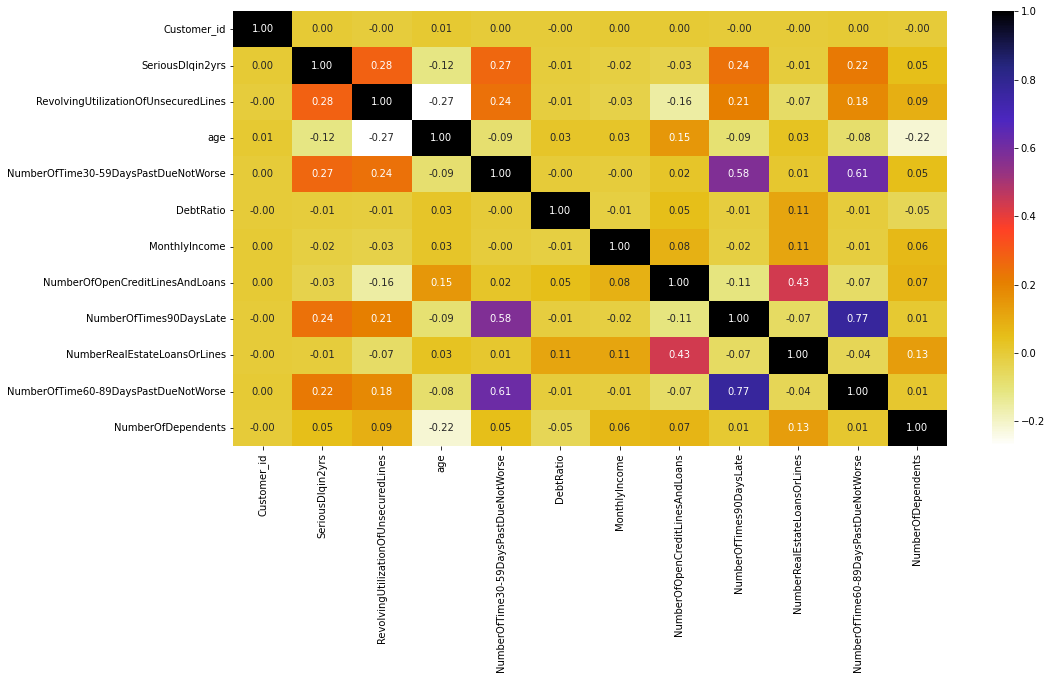

In [48]:
plt.figure(figsize=(16,8))
sns.heatmap(df_train_new.corr(), fmt = '.2f', annot=True, cmap=plt.cm.CMRmap_r)
plt.show();

* From the correlation heatmap above, we can see the most correlated values to SeriousDlqin2yrs are NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate.
* Number of Open Credit Lines and Loans and Number of Real Estate Loans or Lines also have a significant correlation

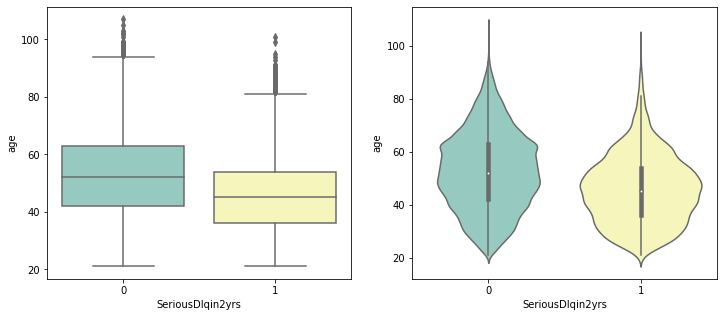

In [49]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'age')

- Age has no significant on the target variable though most of the customers are in the mid 50 who has serious delinquency in 2 years

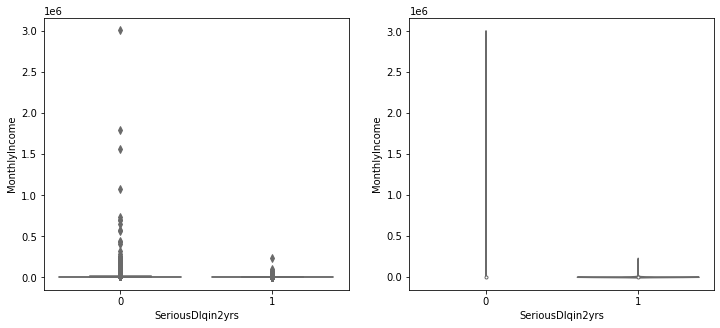

In [50]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'MonthlyIncome')

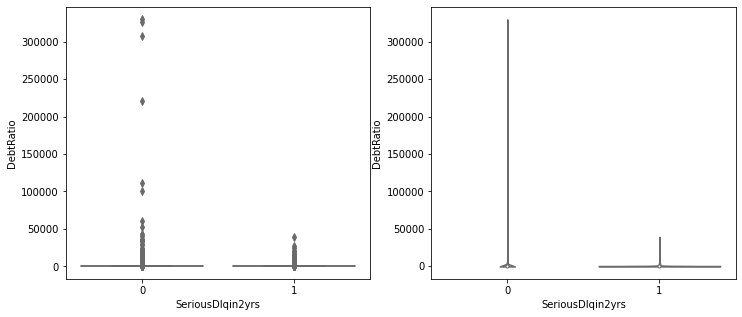

In [51]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'DebtRatio')

* Both MonthlyIncome and Debt ration have similar relationship with the target variable.

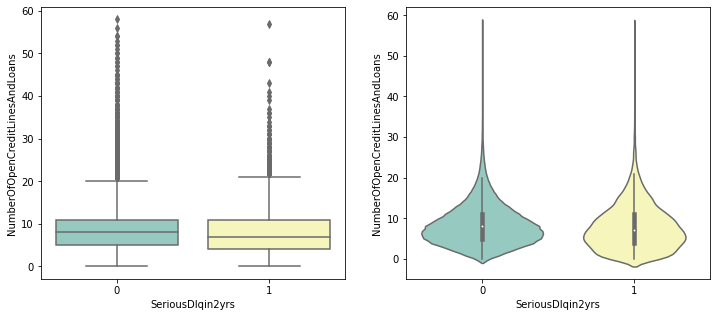

In [52]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'NumberOfOpenCreditLinesAndLoans')

* It is expected that the higher the utlization ratio, the higher the default rate is. Let us look into it by plotting the utlization ratio to default rate

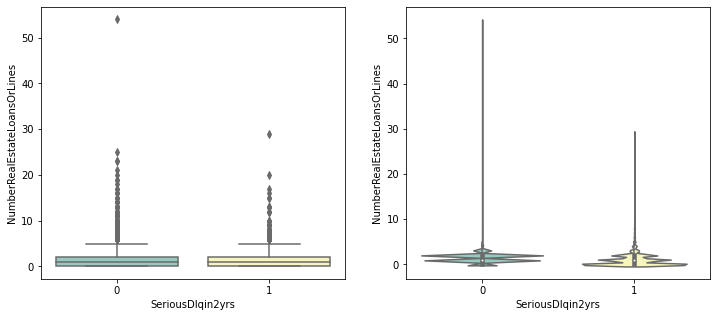

In [53]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'NumberRealEstateLoansOrLines')

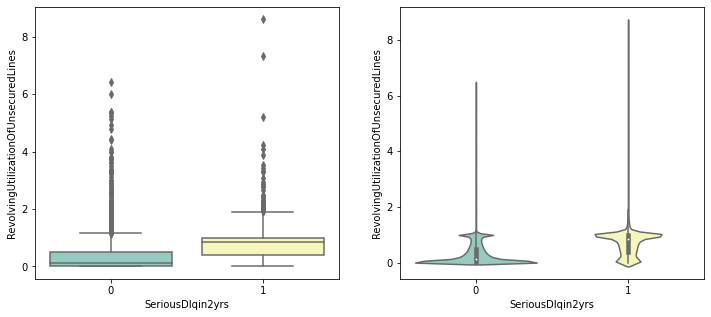

In [54]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines')

- Greater the utlization of the credit resources or the ratio of amount owe to credit, serious delinquency is on a bit higher side

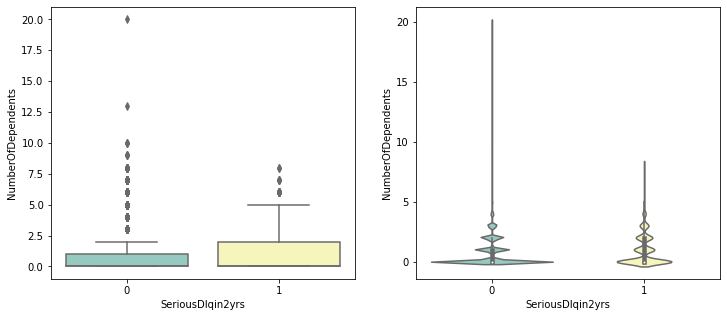

In [55]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'NumberOfDependents')

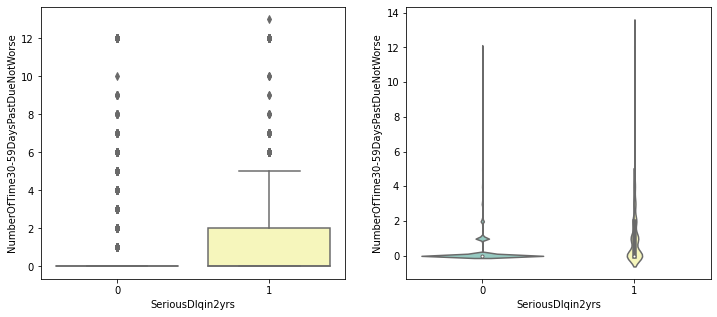

In [56]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'NumberOfTime30-59DaysPastDueNotWorse')

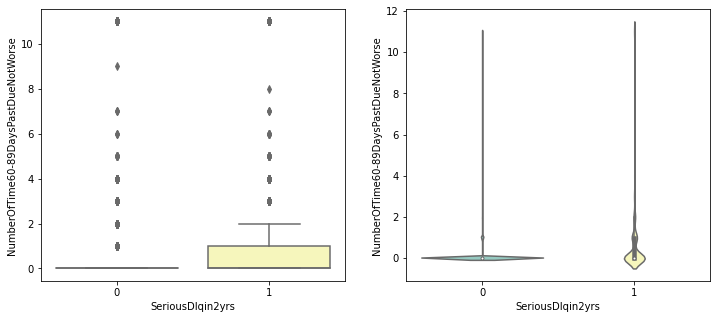

In [57]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'NumberOfTime60-89DaysPastDueNotWorse')

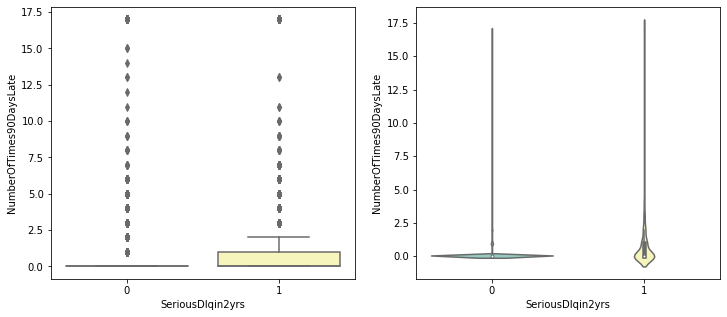

In [58]:
plot_box_violin(df_train_new, 'SeriousDlqin2yrs', 'NumberOfTimes90DaysLate')

## **Feature Engineering**

- Combined Features

In [59]:
for df in [df_train_new, df_val_new]:
    df['CombinedPastDue'] = df['NumberOfTime30-59DaysPastDueNotWorse'] + \
                                df['NumberOfTime60-89DaysPastDueNotWorse'] + \
                                df['NumberOfTimes90DaysLate']
    df['CombinedCreditLoans'] = df['NumberOfOpenCreditLinesAndLoans'] + df['NumberRealEstateLoansOrLines']
    
df_train_new.columns  

Index(['Customer_id', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans'],
      dtype='object')

* Interaction of the features

In [60]:
for df in [df_train_new, df_val_new]:
  
    df['MonthlyIncomePerPerson'] = df['MonthlyIncome']/(df['NumberOfDependents']+1)
    df['MonthlyDebt'] = df['MonthlyIncome']*df['DebtRatio']
    df['isRetired'] = np.where((df['age'] > 65), 1, 0)
    df['RevolvingLines'] = df['NumberOfOpenCreditLinesAndLoans']-df['NumberRealEstateLoansOrLines']
    df['hasRevolvingLines'] = np.where((df['RevolvingLines']>0),1,0)
    df['hasMultipleRealEstates'] = np.where((df['NumberRealEstateLoansOrLines']>=2),1,0)
    df['IsAlone'] = np.where((df['NumberOfDependents']==0),1,0)
    
df_train_new.columns

Index(['Customer_id', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans',
       'MonthlyIncomePerPerson', 'MonthlyDebt', 'isRetired', 'RevolvingLines',
       'hasRevolvingLines', 'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

In [61]:
df_train_new.shape, df_val_new.shape

((119562, 21), (29944, 21))

In [62]:
# Target class distribution
print("Training set: %.2f%%" %(df_train_new['SeriousDlqin2yrs'].sum()/len(df_train_new)*100))
print("\nTesting set: %.2f%%"%(df_val_new['SeriousDlqin2yrs'].sum()/len(df_val_new)*100))

Training set: 6.70%

Testing set: 6.68%


In [63]:
df_train = df_train_new.drop(columns=['Customer_id', 'SeriousDlqin2yrs'],axis=1)
y_train = df_train_new['SeriousDlqin2yrs']

df_val = df_val_new.drop(columns=['Customer_id', 'SeriousDlqin2yrs'],axis=1)
y_val = df_val_new['SeriousDlqin2yrs']

## **Tackling Class Imbalance Problem using: SMOTE**

In [64]:
smote = SMOTE(sampling_strategy = 'minority',k_neighbors = 2,random_state=42)

smote_X, smote_y = smote.fit_resample(df_train,y_train)

In [65]:
smote_X.shape, sum(smote_y)/len(smote_y)

((223114, 19), 0.5)

In [66]:
smote_X.head(10)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,CombinedPastDue,CombinedCreditLoans,MonthlyIncomePerPerson,MonthlyDebt,isRetired,RevolvingLines,hasRevolvingLines,hasMultipleRealEstates,IsAlone
0,0.00,54,0,0.44,5200.00,10,0,2,0,1.00,0,12,2600.00,2275.56,0,8,1,1,0
1,1.00,57,2,0.57,5000.00,3,0,2,0,0.00,2,5,5000.00,2860.43,0,1,1,1,1
2,0.02,60,0,1193.00,5403.00,15,0,1,0,0.00,0,16,5403.00,6445779.00,0,14,1,0,1
3,1.00,26,5,0.23,2000.00,6,1,0,0,0.00,6,6,2000.00,468.77,0,6,1,0,1
4,0.01,52,0,0.52,14500.00,20,0,3,0,0.00,0,23,14500.00,7556.48,0,17,1,1,1
5,0.24,52,0,0.44,6000.00,15,0,2,0,0.00,0,17,6000.00,2610.56,0,13,1,1,1
6,0.50,72,0,0.36,3066.00,10,0,1,0,0.00,0,11,3066.00,1092.64,1,9,1,0,1
7,0.00,22,0,0.00,5403.00,2,0,0,0,0.00,0,2,5403.00,0.00,0,2,1,0,1
8,0.23,36,0,0.12,9083.00,12,0,1,0,1.00,0,13,4541.50,1129.88,0,11,1,0,0
9,0.05,35,0,0.00,5800.00,3,0,0,0,0.00,0,3,5800.00,29.00,0,3,1,0,1


* **Scaling of the features so convergence of the model towards global minima can be achieved and training can be done faster**
* We will be using a couple of Feature Transformation techniques:
* **
    * BoxCox Transformations
    * Standaradization


* We will check with how skewness changes after the transformations and we will check on SMOTE sampling technique dataset    

In [67]:
# Skewness in features before transformation
skewM = SkewMeasure(smote_X)
skewM

,skew
MonthlyIncome,150.30
MonthlyIncomePerPerson,124.05
MonthlyDebt,100.53
DebtRatio,97.63
NumberOfTime60-89DaysPastDueNotWorse,8.80
NumberOfTimes90DaysLate,8.42
CombinedPastDue,8.28
NumberOfTime30-59DaysPastDueNotWorse,5.12
NumberRealEstateLoansOrLines,3.43
isRetired,2.57


## Box cox transformation

In [68]:
smote_X_transformed = pd.DataFrame(columns = smote_X.columns)
df_val_transformed = pd.DataFrame(columns = df_val.columns)

for col in smote_X.columns:
    if col in skewM.index:
        smote_X_transformed[col] = special.boxcox1p(smote_X[col], 0.15) #lambda = 0.15
        df_val_transformed[col] = special.boxcox1p(df_val[col], 0.15) #lambda = 0.15
    else:
        smote_X_transformed[col] = smote_X[col].copy()
        df_val_transformed[col] = df_val[col].copy()
        
SkewMeasure(smote_X_transformed)

,skew
NumberOfTime60-89DaysPastDueNotWorse,4.69
NumberOfTimes90DaysLate,3.78
isRetired,2.57
NumberOfTime30-59DaysPastDueNotWorse,2.09
DebtRatio,2.09
MonthlyDebt,1.91
CombinedPastDue,1.86
hasMultipleRealEstates,1.36
NumberOfDependents,0.78
NumberRealEstateLoansOrLines,0.67


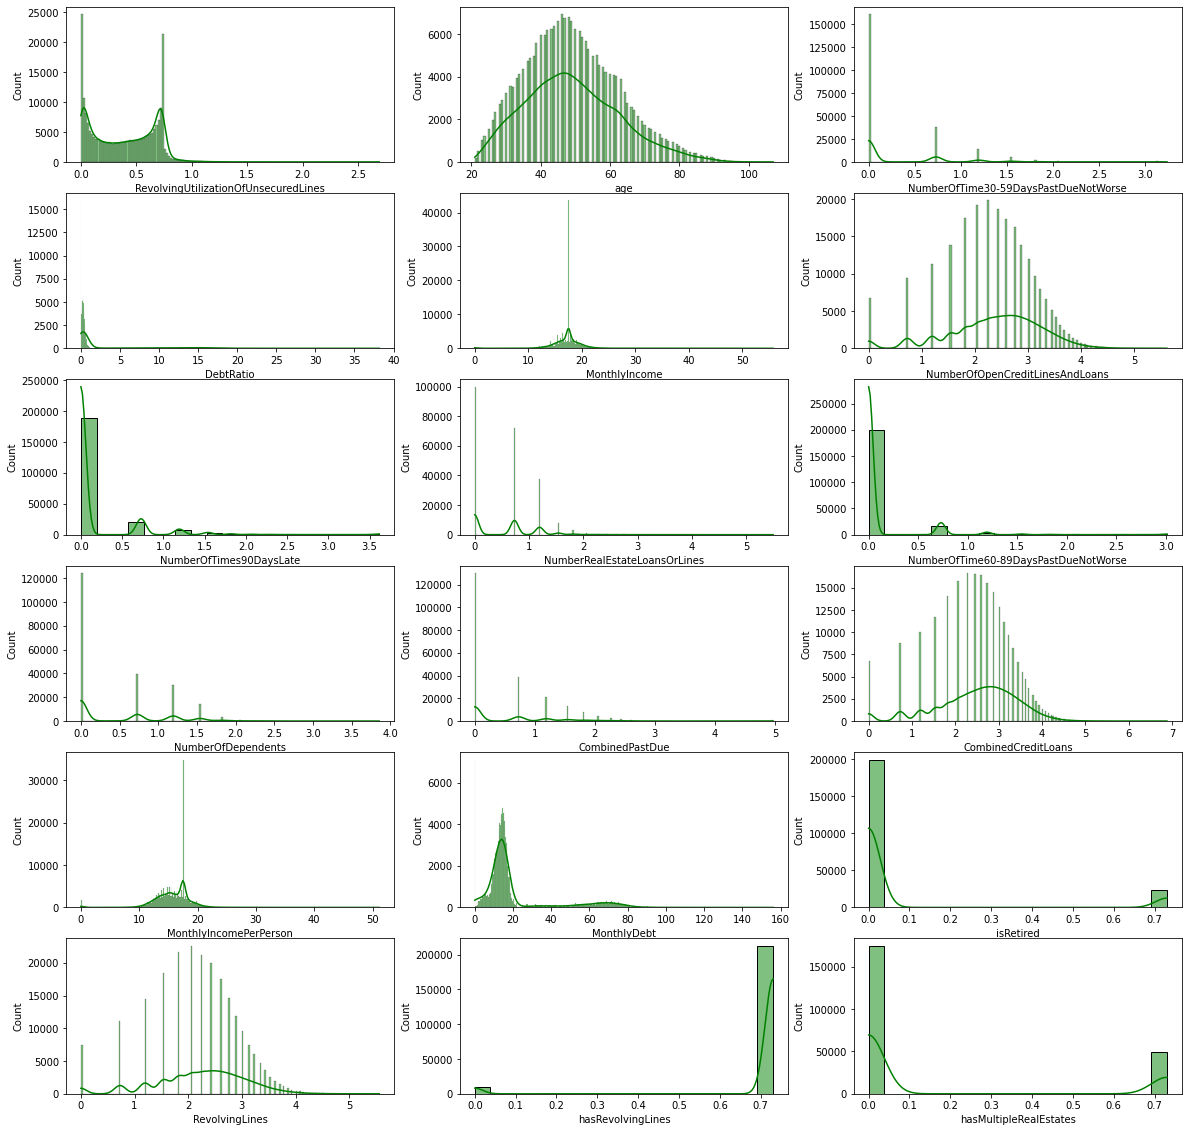

In [69]:
column_list = list(smote_X_transformed.columns)

fig = plt.figure(figsize=[20,20])
for col,i in zip(column_list,range(1,19)):
    ax = fig.add_subplot(6,3,i)
    sns.histplot(data = smote_X_transformed, x = col, ax = ax, kde = True, kde_kws={'bw_adjust':1.5}, color='g')
plt.show();

* Skewness is reduced and now the graphs are looking good

In [70]:
df_train_transformed = df_train.copy()

skewM = SkewMeasure(df_train)

for i in skewM.index:
    df_train_transformed[i] = special.boxcox1p(df_train_transformed[i],0.15) #lambda = 0.15

In [71]:
df_train_transformed.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,CombinedPastDue,CombinedCreditLoans,MonthlyIncomePerPerson,MonthlyDebt,isRetired,RevolvingLines,hasRevolvingLines,hasMultipleRealEstates,IsAlone
120203,0.00,54,0.00,0.37,17.39,2.89,0.00,1.19,0.00,0.73,0.00,3.13,15.02,14.59,0.00,2.60,0.73,0.73,0
37101,0.73,57,1.19,0.47,17.25,1.54,0.00,1.19,0.00,0.00,1.19,2.06,17.25,15.33,0.00,0.73,0.73,0.73,1
3242,0.02,60,0.00,12.63,17.53,3.44,0.00,0.73,0.00,0.00,0.00,3.53,17.53,63.37,0.00,3.34,0.73,0.00,1
76934,0.73,26,2.06,0.21,14.18,2.26,0.73,0.00,0.00,0.00,2.26,2.26,14.18,10.11,0.00,2.26,0.73,0.00,1
140302,0.01,52,0.00,0.43,21.40,3.86,0.00,1.54,0.00,0.00,0.00,4.07,21.40,18.78,0.00,3.62,0.73,0.73,1


## Feature scaling

In [72]:
scaler = MinMaxScaler()

scaler.fit(df_train.to_numpy())

Xs_train_org = scaler.transform(df_train.to_numpy())
Xs_val_org = scaler.transform(df_val.to_numpy())

MinMaxScaler()

In [73]:

scaler = MinMaxScaler()

scaler.fit(smote_X)

Xs_train_smote = scaler.transform(smote_X) 
Xs_val_smote = scaler.transform(df_val)

MinMaxScaler()

# Modelling

* **Training the model :**
* **
* We will be training the model using following algorithms 
    
     * **Logistic Regression**
     * **Random Forest**
     * **XGBoost**
     * **Light GBM**

* We wil also be comparing the results using transformed dataset and the original dataset
* We will check and compare on which algorithms transformations works and on which not.
* We will be doing Cross Validation and will see if the model performance is fluctuating using the statistical measures such as mean and standarad deviation 
       
* **
* **Predicting the customers from the validation set and comparing with the true values from the validation set using different evaluation metrics will indicate that which model is performing the best**
* **
* **We will also be evaluating our model on different metrics and why some metrics might fail in our case study which is one of the most popular metric to evaluate a model performance**
* **
* **Some common evaluation metric you will be seeing across all modeling algorithms are:**
    * **Precision** -  How good a model is in predicting the events (Proportion of positive predictions that are actually positive)
        * $\frac{True Positives} {True Positives + False Positives}$
    
    * **Recall** - * How good a model is able to capture relevant events(Coverage) (Proportion of actual positives that are correctly predicted)
    
        * $\frac {True Positives} {True Positives + False Negatives}$
    * **F1 Score** - * Harmonic mean between Precision and Recall, this metric penalized either one of the lower scorer metric so that trade off can be maintained
    * **Area Under the Curve & ROC** - * how good a model is able to differentiate between the classes
        * It is plotted as False Positive Rate on the x-axis and True Positive Rate on the y-axis  using different thresholds.
        * The more the area or the line it is above straight diagonal line, the better is model performance as comapred to randomly predicting the classes
* **
* **We will be comapring the different modeling techniques AUC results to see which ones are performing better as compared to others**
* **
* **We will be tuning hyper parameters of the models to achieve better results and see how tuning increases performance if it does**

In [74]:
# Function to compute classification metrics
def clf_metrics(val_y, pred_y): 
    '''
    Compute classification metrics
    Args:
       val_y: Truth labels for validation data
       pred_y: predictions for validation data
    Returns:
       precision_macro, precision_micro, recall_macro_, recall_micro, f1_macro, f1_micro, confusion matrix
    '''
    cm = confusion_matrix(val_y, pred_y)
    prec_macro = precision_score(val_y, pred_y, average='macro')*100
    prec_micro = precision_score(val_y, pred_y, average='micro')*100
    rec_macro = recall_score(val_y, pred_y, average='macro')*100
    rec_micro = recall_score(val_y, pred_y, average='micro')*100
    f1_macro = f1_score(val_y, pred_y, average='macro')*100 
    f1_micro = f1_score(val_y, pred_y, average='micro')*100 
    return prec_macro, prec_micro, rec_macro, rec_micro, f1_macro, f1_micro, cm


# Function to train the classifier and get the classification scores
def classifier(clf, X_train, X_val, y_train, y_val):
    '''
    Train the classifier, perform cross validation and return classification scores on validation data
    Args:
       clf: classifier object
       X_train: Training data
       y_train: Training truth labels
       X_val: Validation data
       y_val: validation truth labels
    Returns:
       clf_scores: A pandas series for various classifier metric scores
    '''
    metrics = ['Mean Accuracy', 'Accuracy Std. Dev.', 'Precision Macro', 'Precision Micro', 
               'Recall Macro','Recall Micro', 'F1 Score Macro', 'F1 Score Micro', 'Confusion Matrix']
    score = []
    
    cv_score = cross_val_score(clf, X_train, y_train, cv=5, scoring = 'accuracy')
    mean_acc = round(np.mean(cv_score), 3)*100
    std_acc  = round(np.std(cv_score), 3)*100
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    prec_macro, prec_micro, rec_macro, rec_micro, f1_macro, f1_micro, cm = clf_metrics(y_val, y_pred)

    score.extend([mean_acc, std_acc, prec_macro, prec_micro, rec_macro, rec_micro, f1_macro, f1_micro, cm])
    clf_scores = pd.Series(data = score, index = metrics)
    return clf, clf_scores


def evaluate_clf(dict_clf, train_X, val_X, train_y, val_y):
    '''
    Evaluate the scores of classifiers
    Args:
       dict_clf: dictionary of classifiers
       train_X: Training data
       val_X = validation data
       train_y: Training truth labels
       val_y: Validation truth labels
    Returns:
       fitted_clf_dict: A dictionary of fitted classifiers
       scores_dict: A dataframe of metric scores of each model
    '''
    dict_scores = {}
    dict_fitted_clf = {}

    for key in dict_clf.keys():
        fitted_clf, clf_result = classifier(dict_clf[key], train_X, val_X, train_y, val_y)
        dict_scores[key] = clf_result
        dict_fitted_clf[key] = fitted_clf
        
    return dict_fitted_clf, pd.DataFrame(dict_scores)


def plot_metrics_multiple(models_dict, val_X, val_y):
    '''
    Plotting ROC curve and Precision-Recall curve
    Args:
       models_dict: Dictionary of fitted models
       val_X: Validation data
       val_y: validation truth labels
    '''
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (16,6), sharex=False, sharey=False )
    
    for key in models_dict.keys():
        model = models_dict[key]
        
        if hasattr(model, 'predict_proba'):   
            pred_y = model.predict_proba(val_X)[:,1]
        elif hasattr(model, 'decision_function'):
            pred_y = model.decision_function(val_X)
        else:
            pred_y = model.predict(val_X)   # predicting class
        
        fpr, tpr, thresholds = roc_curve(val_y, pred_y)
        roc_auc = auc(fpr, tpr)
        
        precision, recall, thresh_prc = precision_recall_curve(y_val, pred_y)
        
        ax1.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (key, roc_auc))
        ax2.plot(recall, precision, label='%s' %(key))
    
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('1-Specificity (FPR)', fontsize = 13)
    ax1.set_ylabel('Sensitivity (TPR)', fontsize = 13)
    ax1.set_title('Receiver Operating Characteristic', fontsize = 13)
    ax1.legend(loc="lower right", fontsize = 12)
    
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall', fontsize = 13)
    ax2.set_ylabel('Precision', fontsize = 13)
    ax2.set_title("Precision-Recall curve", fontsize = 13)
    ax2.legend(loc="upper right", fontsize=12)
    return


## Training and evaluating classifiers by providing class weights to handle class imbalance

In [75]:
# Obtaining class weights based on the class samples imbalance ratio
vals, num_samples = np.unique(y_train, return_counts = True)
weights = np.max(num_samples)/num_samples
print("Unique class labels:\t ",vals)
print("Corresponding class weights", weights)
print("No. of class samples\t", num_samples)

Unique class labels:	  [0 1]
Corresponding class weights [ 1.         13.93591505]
No. of class samples	 [111557   8005]


In [76]:
weights_dict = dict()
for a,b in zip(vals,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0, 1: 13.935915053091817}

In [77]:
clf_dict_balanced = {
    'Logistic Regression' : LogisticRegression(random_state = 101, class_weight = weights_dict, max_iter = 300),
    'Random Forest': RandomForestClassifier(random_state = 101, class_weight = weights_dict),
    'XGBoost': XGBClassifier(random_state = 101, scale_pos_weight = weights_dict[1]),
    'Light GBM' : LGBMClassifier(random_state = 101, scale_pos_weight = weights_dict[1])
}

#### On unscaled original data

In [78]:
models_org, org_clf_scores = evaluate_clf(clf_dict_balanced, 
                                          df_train.to_numpy(), df_val.to_numpy(),
                                          y_train.to_numpy(), y_val.to_numpy())

In [79]:
org_clf_scores

,Logistic Regression,Random Forest,XGBoost,Light GBM
Mean Accuracy,84.80,93.50,83.50,80.90
Accuracy Std. Dev.,5.40,0.10,0.20,0.40
Precision Macro,50.94,73.66,60.17,59.92
Precision Micro,85.42,93.43,82.39,80.18
Recall Macro,51.29,56.74,76.25,78.50
Recall Micro,85.42,93.43,82.39,80.18
F1 Score Macro,50.95,59.61,62.13,61.19
F1 Score Micro,85.42,93.43,82.39,80.18
Confusion Matrix,"[[25340, 2603], [1763, 238]]","[[27689, 254], [1713, 288]]","[[23288, 4655], [617, 1384]]","[[22477, 5466], [469, 1532]]"


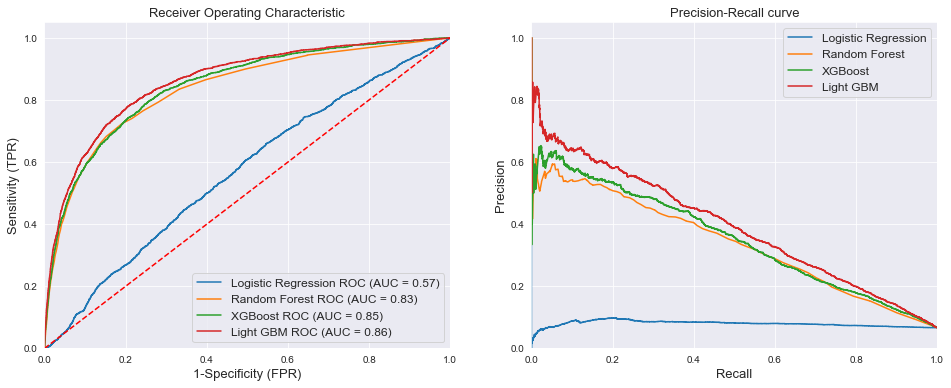

In [80]:
sns.set_style('darkgrid')
plot_metrics_multiple(models_org, df_val.to_numpy(), y_val.to_numpy())
plt.show();

#### On scaled original data

In [81]:
models_org_scaled, org_scaled_clf_scores = evaluate_clf(clf_dict_balanced, Xs_train_org, Xs_val_org, 
                                                        y_train.to_numpy(), y_val.to_numpy())

In [82]:
org_scaled_clf_scores

,Logistic Regression,Random Forest,XGBoost,Light GBM
Mean Accuracy,80.10,93.40,83.50,80.90
Accuracy Std. Dev.,0.40,0.10,0.20,0.40
Precision Macro,59.62,73.28,60.16,59.92
Precision Micro,79.94,93.41,82.45,80.18
Recall Macro,77.65,57.43,76.12,78.50
Recall Micro,79.94,93.41,82.45,80.18
F1 Score Macro,60.76,60.47,62.13,61.19
F1 Score Micro,79.94,93.41,82.45,80.18
Confusion Matrix,"[[22436, 5507], [500, 1501]]","[[27653, 290], [1683, 318]]","[[23313, 4630], [624, 1377]]","[[22477, 5466], [469, 1532]]"


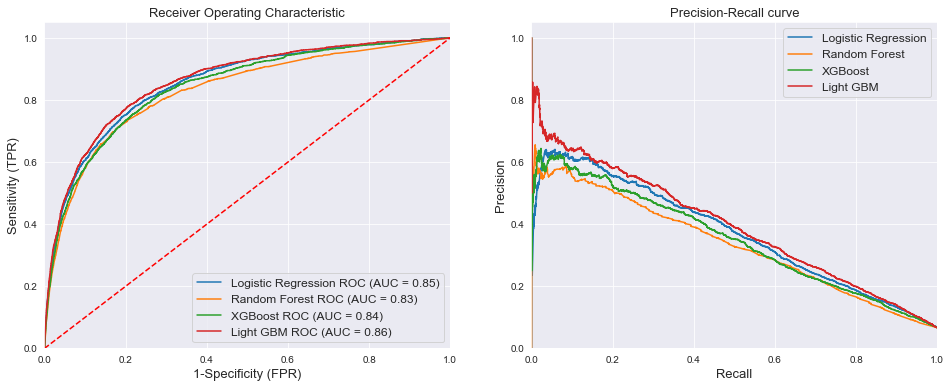

In [83]:
plot_metrics_multiple(models_org_scaled, Xs_val_org, y_val.to_numpy())
plt.show();

* **Logistic Regression metrics are changed while all other model metrics remain nearly same**
* Hence, Logistic Regression algorithm requires scaling of features whereas tree based doesn't

## Training and evaluating the classifiers without specifying the class weights

In [84]:
clf_dict = {
    'Logistic Regression' : LogisticRegression(random_state = 101, solver = 'newton-cg'),
    'Random Forest': RandomForestClassifier(random_state = 101),
    'XGBoost': XGBClassifier(random_state = 101),
    'Light GBM' : LGBMClassifier(random_state = 101)
}

#### On box-cox transformed data

In [85]:
models_box_cox_smote, box_cox_smote_clf_scores = evaluate_clf(clf_dict, smote_X_transformed, 
                                                              df_val_transformed, smote_y, y_val)

In [86]:
box_cox_smote_clf_scores

,Logistic Regression,Random Forest,XGBoost,Light GBM
Mean Accuracy,80.20,93.40,88.10,85.80
Accuracy Std. Dev.,0.60,2.00,2.40,1.70
Precision Macro,59.62,63.44,60.39,60.04
Precision Micro,81.56,89.41,85.77,83.25
Recall Macro,75.53,69.71,70.96,74.44
Recall Micro,81.56,89.41,85.77,83.25
F1 Score Macro,61.25,65.72,62.81,62.15
F1 Score Micro,81.56,89.41,85.77,83.25
Confusion Matrix,"[[23051, 4892], [629, 1372]]","[[25834, 2109], [1061, 940]]","[[24604, 3339], [923, 1078]]","[[23641, 4302], [715, 1286]]"


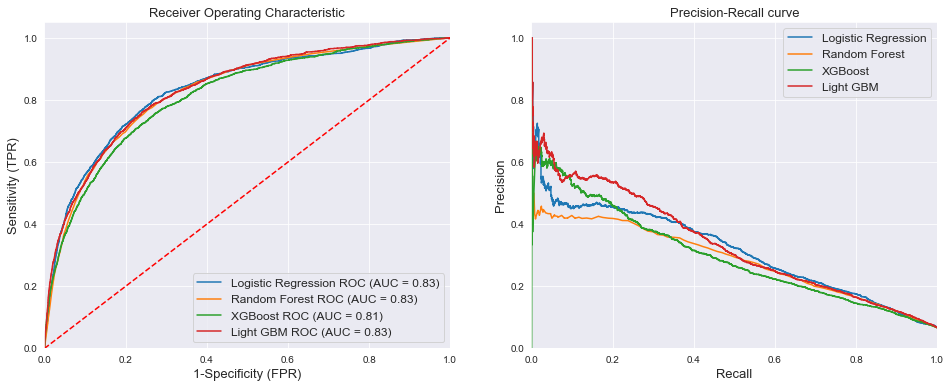

In [87]:
plot_metrics_multiple(models_box_cox_smote, df_val_transformed, y_val)
plt.show();

#### On scaled smote data

In [88]:
models_scaled_smote, scaled_smote_clf_scores = evaluate_clf(clf_dict, Xs_train_smote, Xs_val_smote, smote_y, y_val)

In [89]:
scaled_smote_clf_scores

,Logistic Regression,Random Forest,XGBoost,Light GBM
Mean Accuracy,80.70,92.60,88.10,85.80
Accuracy Std. Dev.,0.90,1.90,2.40,1.70
Precision Macro,59.08,62.76,60.60,60.04
Precision Micro,80.77,88.71,85.88,83.25
Recall Macro,74.62,70.27,71.37,74.44
Recall Micro,80.77,88.71,85.88,83.25
F1 Score Macro,60.37,65.25,63.08,62.15
F1 Score Micro,80.77,88.71,85.88,83.25
Confusion Matrix,"[[22836, 5107], [650, 1351]]","[[25584, 2359], [1021, 980]]","[[24622, 3321], [908, 1093]]","[[23641, 4302], [715, 1286]]"


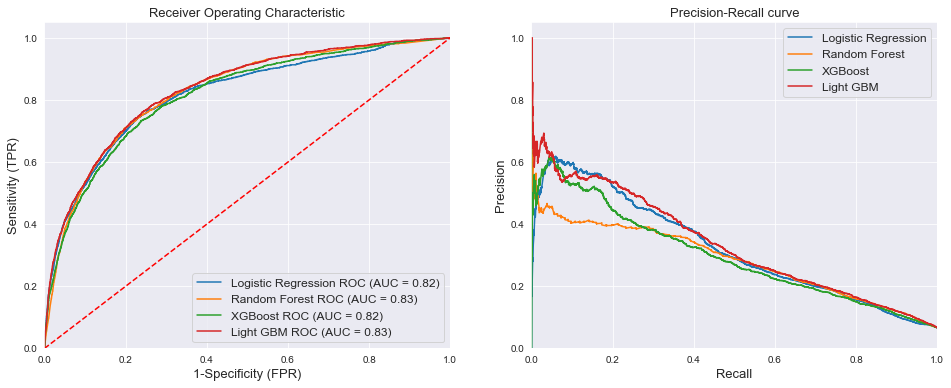

In [90]:
plot_metrics_multiple(models_scaled_smote, Xs_val_smote, y_val)
plt.show();

* **Key takeaways:**
* **
* Tree Based model doesn't require scaling of the features
* Statistical - Logistic Regression requires scaling of the features
* SMOTE sampling results are not better as compared to using class weights in the model itself
    

**We will be proceeding with the original dataset with scaling of the featues but using class weights in the model itself**

### Hyperparameter tuning of the models

In [107]:
def fit_grid_search(clf, train_X, train_y, params_grid):
    '''
    Hyperparameter tuning using GridSearchCV and return the fitted best model
    '''
    if 'logistic' in str(clf).lower():
        model = GridSearchCV(clf, param_grid = params_grid, cv = StratifiedKFold(3), 
                             verbose=2, n_jobs=-1, scoring = 'recall')
    
    if 'random' in str(clf).lower():
        model = GridSearchCV(clf, param_grid = params_grid, cv = StratifiedKFold(3), scoring = 'recall')
    
    if 'xg' in str(clf).lower():
        model = GridSearchCV(clf, param_grid = params_grid, scoring="recall", 
                             cv = StratifiedKFold(3), n_jobs = -1, verbose = 2)
    if 'gbm' in str(clf).lower():
        model = GridSearchCV(estimator = clf, param_grid = params_grid, scoring = 'recall',
                             cv = StratifiedKFold(3), n_jobs = -1, verbose = 2)
    model.fit(train_X, train_y)
    best_est = model.best_estimator_
    return best_est

# Function to tune tree based models
def hyperparameter_tuning(clf, train_X, train_y):
    '''
    Function to perform Hyperparamter tuning of Tree based models
    '''
    if 'random' in str(clf).lower():
        params_grid={
            "n_estimators":[200, 300],
            "max_depth":[7,12],
            "min_samples_leaf":[2,4,8],
            'class_weight' : [{0:1, 1:12},{0:1, 1:15}]
        }
        best_model = fit_grid_search(clf, train_X, train_y, params_grid)
        
    if 'xg' in str(clf).lower():
        params_grid = {
            'n_estimators': [100, 200], 
            'max_depth': [7, 10], 
            'gamma' : [0.25,0.5,1],
            'reg_alpha': [0.1, 10, 100],
            'reg_lambda': [0.1, 10, 100],
            'scale_pos_weight' : [12,15]
        }
        best_model = fit_grid_search(clf, train_X, train_y, params_grid)
        
    if 'gbm' in str(clf).lower():
        params_grid = {
            'n_estimators': [100,250,400],
            'min_split_gain' : [0.25,0.45,0.7],
            'max_depth': [7,10],
            'subsample': [0.65,0.85],
            'colsample_bytree': [0.45,0.65],
            'reg_lambda': [0.1, 10, 100],
            'num_leaves' : [30,50],
            'scale_pos_weight' : [12,15]
         }
        best_model = fit_grid_search(clf, train_X, train_y, params_grid)
        
    return best_model

In [101]:
clf_dict_balanced = {
    'Logistic Regression' : LogisticRegression(random_state = 125, max_iter = 2000),
    'Random Forest': RandomForestClassifier(random_state = 125),
    'XGBoost': XGBClassifier(random_state = 125),
    'Light GBM' : LGBMClassifier(random_state = 125)
}


tuned_models = {}
tuned_models_metrics = {}

In [104]:
# Hyperparameter tuning of Logistic Regression model
params_grid_logit = {
            'C' : np.logspace(-2, 2, 10),
            'class_weight' : [{0:1, 1:12},{0:1, 1:15}]
        }

tuned_models['Logistic Regression'] = fit_grid_search(clf_dict_balanced['Logistic Regression'], 
                                                        Xs_train_org, y_train, params_grid_logit)

In [105]:
evaluate_clf(tuned_models, Xs_train_org, Xs_val_org, y_train, y_val)

({'Logistic Regression': LogisticRegression(C=100.0, class_weight={0: 1, 1: 15}, max_iter=2000,
                     random_state=125)},
                              Logistic Regression
 Mean Accuracy                              78.80
 Accuracy Std. Dev.                          0.40
 Precision Macro                            59.30
 Precision Micro                            78.85
 Recall Macro                               77.72
 Recall Micro                               78.85
 F1 Score Macro                             60.01
 F1 Score Micro                             78.85
 Confusion Matrix    [[22082, 5861], [472, 1529]])

In [108]:
for key in clf_dict_balanced.keys():
    if key.lower() == 'logistic regression':
        continue
    else:    
        tuned_models[key] = hyperparameter_tuning(clf_dict_balanced[key], Xs_train_org, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[20:41:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
Fitting 3 folds for each of 864 candidates, totalling 2592 fits


In [109]:
tuned_models_fitted, tuned_models_metrics = evaluate_clf(tuned_models, Xs_train_org, Xs_val_org, y_train, y_val)

In [110]:
tuned_models_fitted

{'Logistic Regression': LogisticRegression(C=100.0, class_weight={0: 1, 1: 15}, max_iter=2000,
                    random_state=125),
 'Random Forest': RandomForestClassifier(class_weight={0: 1, 1: 15}, max_depth=7,
                        min_samples_leaf=8, n_estimators=300, random_state=125),
 'XGBoost': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=125,
               reg_alpha=1

In [111]:
tuned_models_metrics

,Logistic Regression,Random Forest,XGBoost,Light GBM
Mean Accuracy,78.80,80.40,80.80,79.40
Accuracy Std. Dev.,0.40,0.40,0.30,0.40
Precision Macro,59.30,59.61,59.90,59.58
Precision Micro,78.85,79.90,80.21,78.81
Recall Macro,77.72,77.66,78.38,78.83
Recall Micro,78.85,79.90,80.21,78.81
F1 Score Macro,60.01,60.73,61.18,60.31
F1 Score Micro,78.85,79.90,80.21,78.81
Confusion Matrix,"[[22082, 5861], [472, 1529]]","[[22424, 5519], [499, 1502]]","[[22493, 5450], [475, 1526]]","[[22020, 5923], [423, 1578]]"


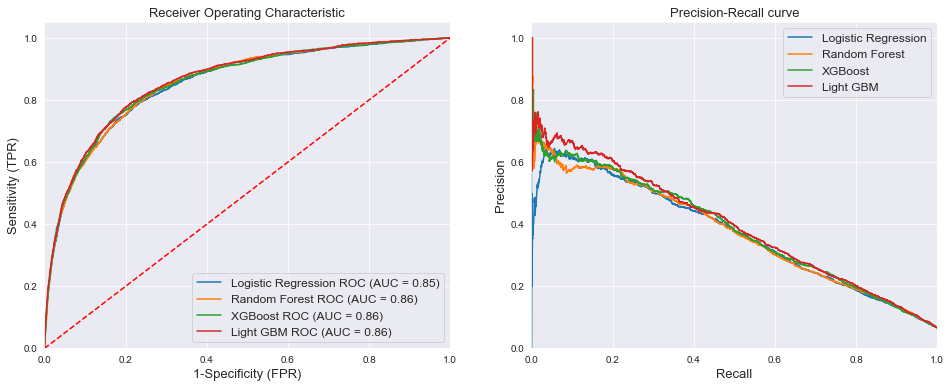

In [112]:
plot_metrics_multiple(tuned_models_fitted, Xs_val_org, y_val.to_numpy())
plt.show();